### Import library

In [108]:
import sys
import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob

### Setting seed

In [109]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

### Read csv file

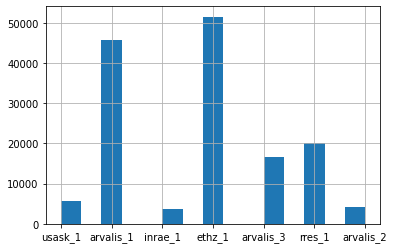

In [110]:
data = pd.read_csv('../input/global-wheat-detection/train.csv')

bboxs = np.stack(data['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    data[column] = bboxs[:,i]
data.drop(columns=['bbox'], inplace=True)

data['source'].hist(bins=15)

### Create kfold 

In [111]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = data[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = data[['image_id', 'source']].groupby('image_id').min()['source']

# Why choose 15?
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)

df_folds.loc[:, 'fold'] = 0
for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/home/trinhnh/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


### Dataset

In [112]:
TRAIN_ROOT_PATH = '../input/global-wheat-detection/train'

# use cutmix method
# https://paperswithcode.com/paper/cutmix-regularization-strategy-to-train
class WheatDataset(Dataset):
    def __init__(self, data_frame, image_ids, transforms=None, test=False):
        super(WheatDataset, self).__init__()
        self.image_ids = image_ids
        self.data_frame = data_frame
        self.transforms = transforms
        self.test = test
        
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        
        if self.test or random.random() > 0.5:
            image, boxes = self.load_image_and_boxes(idx)
        else:
            image, boxes = self.load_cutmix_image_and_boxes(idx)
            
        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['label'] = labels
        target['image_id'] = torch.tensor([idx])
        
#         if self.transforms:
#             for i in range(10):
#                 sample = self.transforms(**{
#                     'image': image,
#                     'bboxes': target['boxes']
#                     'labels': labels
#                 })
#                 if len(sample['bboxes']) > 0:
#                     image = sample['image']
#                     target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
#                     target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
#                     break
        
        return image, target, image_id
        
    
    def __len__(self):
        return self.image_ids.shape[0]
    
    
    def load_image_boxes(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(TRAIN_ROOT_PATH, image_id+'.jpg')
        
        image = cv2.imread(img_path, cv2.IMREAD_ANYCOLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        # normalization
        img /= 255.0
        
        # get x, y, w, h information
        boxes = self.data_frame[self.data_frame['image_id'] == image_id][['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2] # convert w -> x
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3] # convert h -> y

        return image, boxes
                
    
    def load_cutmix_image_boxes(self, idx, imsize=1024):
        w, h = imsize, imsize
        s = imsize // 2
        
        xc, yc = [int(random.uniform(imsize*0.25, imsize*0.75)) for _ in range(2)]
        idxs = [idx] + [random.randint(0, self.image_ids.shape[0] -1) for _ in range(3)]
        
        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []
        
        for i, idx in enumerate(idxs):
            image, boxes = self.load_image_boxes(idx)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh
            
            result_boxes.append(boxes)
        
        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes